In [54]:
import sys
sys.path.append('O:\\68707\\JoelHoward\\DataAnalysis\\QuantumDataProcessModule')
import qdpm
sys.path.append(r'O:\68707\JoelHoward\DataAnalysis')

from qutip import ket2dm, identity, Qobj, tensor, basis, average_gate_fidelity, to_super, choi_to_super, sigmax, sigmay, sigmaz, qeye
from qutip.qip.operations import rx, ry, cphase, rz

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from pathlib import Path
%matplotlib inline

sys.path.append("O:\\68707\\JoelHoward\\OptimalControl")
import NQubitSystem_qutip as NQS_QT
sys.path.append('O:\\68707\\JoelHoward\\PulseShaping')
import AdvancedWaveforms_JH as wfm_adv
from WaveformConstructorPrimitives_JH import *
from pulseGenFuncs import Paths

sys.path.append('O:\\68707\\JoelHoward\\OptimalControl\\AlexOptim_JH')
from optim_gate_gauss_core import NielsenFidelity, evolution, gate

import torch
from forest.benchmarking.operator_tools import kraus2pauli_liouville
from scipy import stats

In [2]:
preparation = [identity(2),
                   rx(np.pi),
                   ry(np.pi/2),
                   ry(-np.pi/2),
                   rx(-np.pi/2),
                   rx(np.pi/2)]
rotation = [identity(2), 
            rx(-np.pi/2), 
            ry(np.pi/2)]
init_state = [basis(2,0), basis(2, 0)]

In [3]:
qSys = NQS_QT.NQubitSystem_QT(Path(r'C:\Users\68707\Desktop\LV_JH\Experiments\JH\Cooldown_2022_01_10\SSB\CNOT\7.5MHz\20Points\gateData_noSavedTomo\G0\results\gate\2022-03-11_0'))
qSys.numLevels = 2

ket00 = qSys.qutipState([0,0])
ket01 = qSys.qutipState([0,1])
ket10 = qSys.qutipState([1,0])
ket11 = qSys.qutipState([1,1])

basePath = Path(r"C:\Users\68707\Desktop\LV_JH\Experiments\JH\Cooldown_2022_01_10\SSB\CNOT\7.5MHz\20Points")
gateDataPath = basePath / 'gates.json'

# Plot

In [40]:
gates = wfm_adv.loadGates(qSys, gateDataPath)
numGates = len(gates)

TheoryGate = gate(qSys, 'CNOT').numpy()

studyPath_I = Path(r"C:\Users\68707\Desktop\LV_JH\Experiments\JH\Cooldown_2022_01_10\SSB\ProcessTomographyTest\id")
paths_I = Paths(studyPath_I)

R_I = qdpm.ProcessTomography(qdpm.Experiment(paths_I.resultsPath('2022-03-11_0')), init_state, preparation, rotation)._R_mle

G_T = list()
G_IF_Exp_Theory = list()
G_IF_Theory_TheoryGate = list()
G_IF_Exp_TheoryGate = list()

g_i = 2
numRepeats = 500
windowSize = 50
numWindows = 10
lastStartIndex = numRepeats - windowSize
startIndices = [int(i) for i in np.linspace(0,lastStartIndex, numWindows)]
print(startIndices)

(2, 2, 85, 500, 4)
[0, 50, 100, 150, 200, 250, 300, 350, 400, 450]


In [41]:
for startIndex in startIndices:
    studyPaths = Paths(basePath / 'gateData_noSavedTomo' / ('G'+str(g_i)))
    tomo = qdpm.ProcessTomography(qdpm.Experiment(studyPaths.resultsPath('2022-03-11_0'), repeatRange=[startIndex, startIndex+windowSize]), init_state, preparation, rotation)
    gateExpSlice = gates[g_i]

    G_T.append(sum([pulse.duration for pulse in gateExpSlice.opList[0].pulseList]))

    U = NQS_QT.unitaryFromOpList(qSys.gateExpSliceToUnitaryOpList(gateExpSlice))
    U_qt = Qobj(U, dims=[[2,2],[2,2]])

    R_U = tomo._R_mle
    R_spamFree = qdpm.R_SPAMfree(U, R_U, R_I)
    tomo._R_mle = R_spamFree.astype('float64')

    G_IF_Exp_Theory.append(1-tomo.fidelity(U_qt))

    G_IF_Theory_TheoryGate.append(1-NielsenFidelity(qSys.N, torch.tensor(U, dtype=torch.cdouble), torch.tensor(TheoryGate, dtype=torch.cdouble)).item())
    G_IF_Exp_TheoryGate.append(1-tomo.fidelity(Qobj(TheoryGate, dims=[[2,2],[2,2]])))

# if g_i == 15:
#     tomo.plot()
#     plt.savefig('CNOT75hist_exp.png', dpi=500)

#         tomo.plot_theory(Qobj(TheoryGate, dims=[[2,2],[2,2]]))
#         plt.savefig('CNOT75hist_theory.png', dpi=500)

[85 50  4]
(2, 2, 85, 50, 4)


<ipython-input-41-d7164d3086d7>:13: ComplexWarning: Casting complex values to real discards the imaginary part
  tomo._R_mle = R_spamFree.astype('float64')


[85 50  4]
(2, 2, 85, 50, 4)


<ipython-input-41-d7164d3086d7>:13: ComplexWarning: Casting complex values to real discards the imaginary part
  tomo._R_mle = R_spamFree.astype('float64')


[85 50  4]
(2, 2, 85, 50, 4)


<ipython-input-41-d7164d3086d7>:13: ComplexWarning: Casting complex values to real discards the imaginary part
  tomo._R_mle = R_spamFree.astype('float64')


[85 50  4]
(2, 2, 85, 50, 4)


<ipython-input-41-d7164d3086d7>:13: ComplexWarning: Casting complex values to real discards the imaginary part
  tomo._R_mle = R_spamFree.astype('float64')


[85 50  4]
(2, 2, 85, 50, 4)


<ipython-input-41-d7164d3086d7>:13: ComplexWarning: Casting complex values to real discards the imaginary part
  tomo._R_mle = R_spamFree.astype('float64')


[85 50  4]
(2, 2, 85, 50, 4)


<ipython-input-41-d7164d3086d7>:13: ComplexWarning: Casting complex values to real discards the imaginary part
  tomo._R_mle = R_spamFree.astype('float64')


[85 50  4]
(2, 2, 85, 50, 4)


<ipython-input-41-d7164d3086d7>:13: ComplexWarning: Casting complex values to real discards the imaginary part
  tomo._R_mle = R_spamFree.astype('float64')


[85 50  4]
(2, 2, 85, 50, 4)


<ipython-input-41-d7164d3086d7>:13: ComplexWarning: Casting complex values to real discards the imaginary part
  tomo._R_mle = R_spamFree.astype('float64')


[85 50  4]
(2, 2, 85, 50, 4)


<ipython-input-41-d7164d3086d7>:13: ComplexWarning: Casting complex values to real discards the imaginary part
  tomo._R_mle = R_spamFree.astype('float64')


[85 50  4]
(2, 2, 85, 50, 4)


<ipython-input-41-d7164d3086d7>:13: ComplexWarning: Casting complex values to real discards the imaginary part
  tomo._R_mle = R_spamFree.astype('float64')


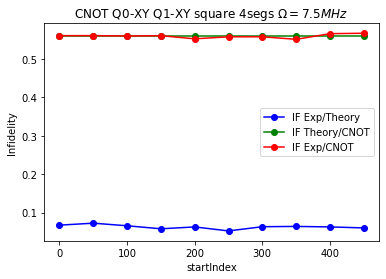

In [42]:
plt.plot(startIndices, G_IF_Exp_Theory, 'bo-', label='IF Exp/Theory')
plt.plot(startIndices, G_IF_Theory_TheoryGate, 'go-', label='IF Theory/CNOT')
plt.plot(startIndices, G_IF_Exp_TheoryGate, 'ro-', label='IF Exp/CNOT')

plt.legend()
# plt.legend(['IF Theory/CNOT', 'IF Exp/CNOT'])
plt.title('CNOT Q0-XY Q1-XY square 4segs $\Omega=7.5MHz$ ')
plt.xlabel('startIndex')
plt.ylabel('Infidelity')
plt.show()

In [53]:
def CI(sample):
    return stats.t.interval(0.95, len(sample)-1, loc=np.mean(sample), scale=stats.sem(sample))

blueData = np.array(G_IF_Exp_Theory)
redData = np.array(G_IF_Exp_TheoryGate)

print(np.round(blueData,3))
print(np.round(redData,3))
print(np.std(blueData))
print(np.std(redData))

[0.067 0.072 0.066 0.058 0.063 0.052 0.063 0.064 0.063 0.06 ]
[0.56  0.561 0.56  0.56  0.552 0.557 0.557 0.551 0.566 0.567]
0.00514930180461797
0.004760989867325565


In [52]:
CI(blueData)

(0.05888811396381974, 0.0666538006041075)